In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm

sns.set_style('darkgrid')

# Dataset Exploration

In [2]:
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
print(train.shape)
train.head()

(18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


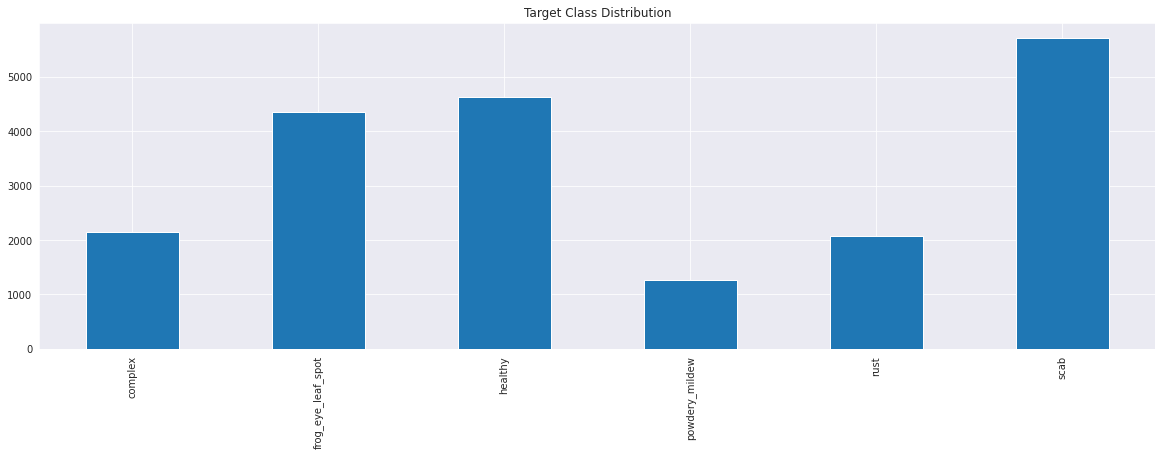

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.labels.apply(lambda x: x.split()))
labels = pd.DataFrame(mlb.transform(train.labels.apply(lambda x: x.split())), columns=mlb.classes_)

fig, ax = plt.subplots(figsize=(20, 6))
labels.sum().plot.bar(title='Target Class Distribution');

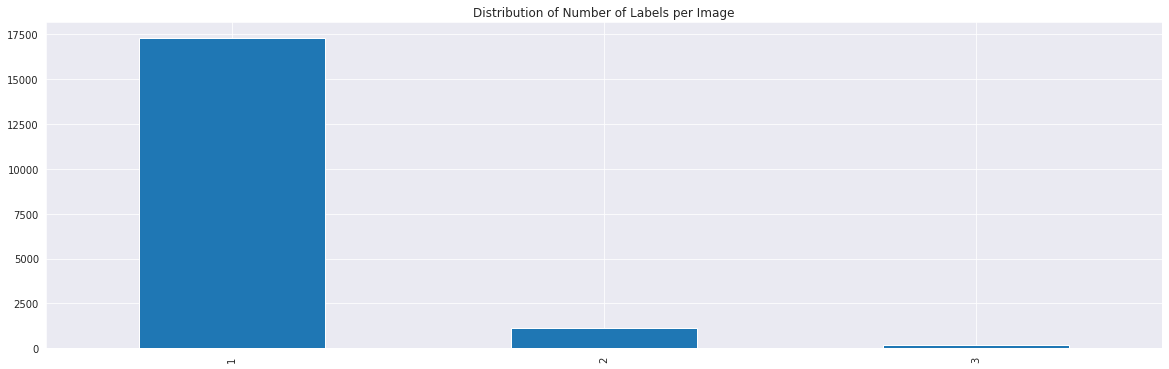

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
labels.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image');

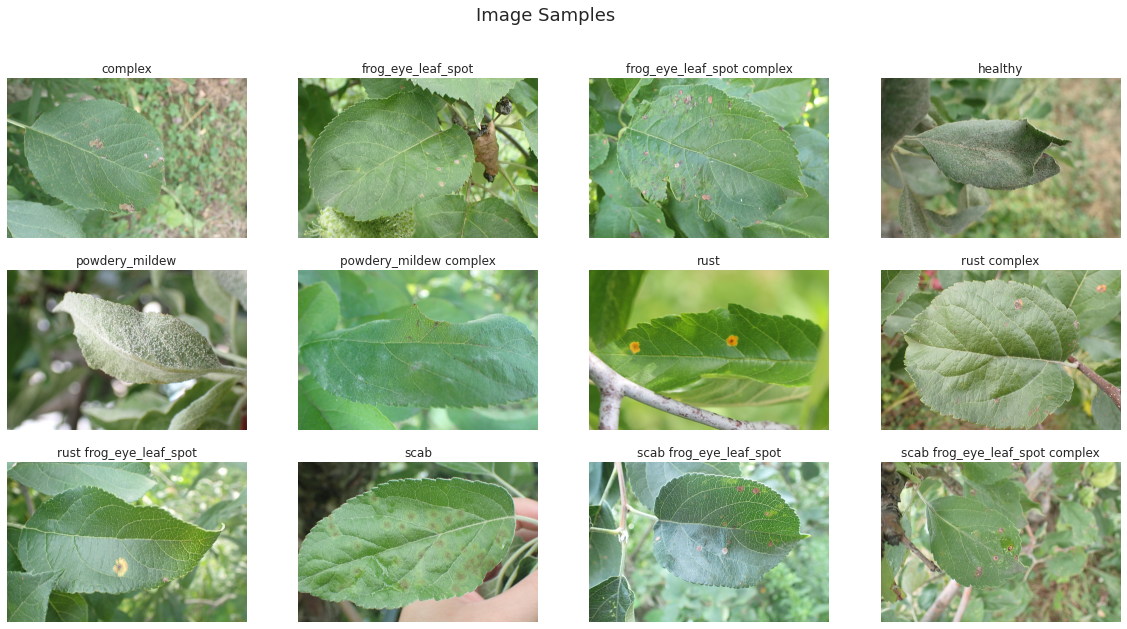

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, img in enumerate(train.groupby('labels').first().reset_index().values):
    ax[i//4][i%4].imshow(plt.imread(f"../input/plant-pathology-2021-fgvc8/train_images/{img[1]}"))
    ax[i//4][i%4].set_title(img[0])
    ax[i//4][i%4].axis('off')
fig.suptitle('Image Samples', fontsize=18); 

# Preprocessing and Augmentation

In [6]:
labels = pd.concat([train['image'], labels], axis=1).drop('healthy', axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0


In [7]:
batch_size=128
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='../input/plant-pathology-2021-fgvc8/train_images',
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='training'
)

valid_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='../input/plant-pathology-2021-fgvc8/train_images',
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation'
)

Found 16769 validated image filenames.
Found 1863 validated image filenames.


# Modelling

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


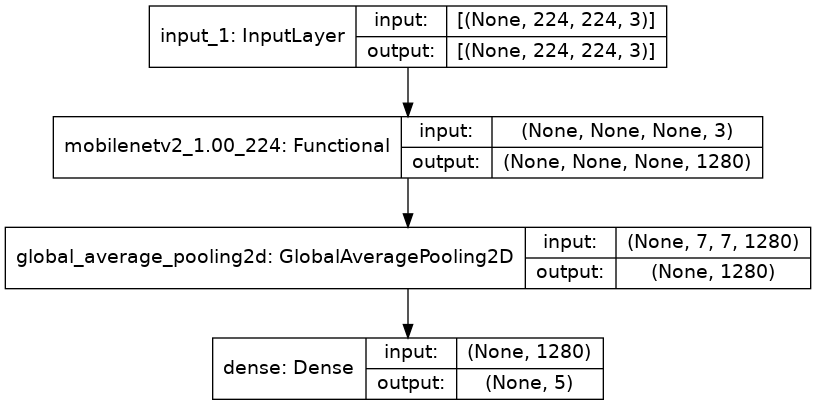

In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(5, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[rlp, es])

Epoch 1/10
132/132 [==============================] - 2728s 21s/step - loss: 0.3802 - val_loss: 0.9195
Epoch 2/10
132/132 [==============================] - 2492s 19s/step - loss: 0.1286 - val_loss: 0.7178
Epoch 3/10
132/132 [==============================] - 2399s 18s/step - loss: 0.0877 - val_loss: 0.5131
Epoch 4/10
132/132 [==============================] - 2409s 18s/step - loss: 0.0534 - val_loss: 0.6190

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 5/10
132/132 [==============================] - 2599s 20s/step - loss: 0.0360 - val_loss: 0.4662
Epoch 6/10
132/132 [==============================] - 2581s 20s/step - loss: 0.0351 - val_loss: 0.3851
Epoch 7/10
132/132 [==============================] - 2606s 20s/step - loss: 0.0344 - val_loss: 0.3349
Epoch 8/10
132/132 [==============================] - 2652s 20s/step - loss: 0.0334 - val_loss: 0.2977
Epoch 9/10
132/132 [==============================] - 2649s 20s/step - loss: 0.0319 - val_loss:

<AxesSubplot:title={'center':'Model Loss Curve'}>

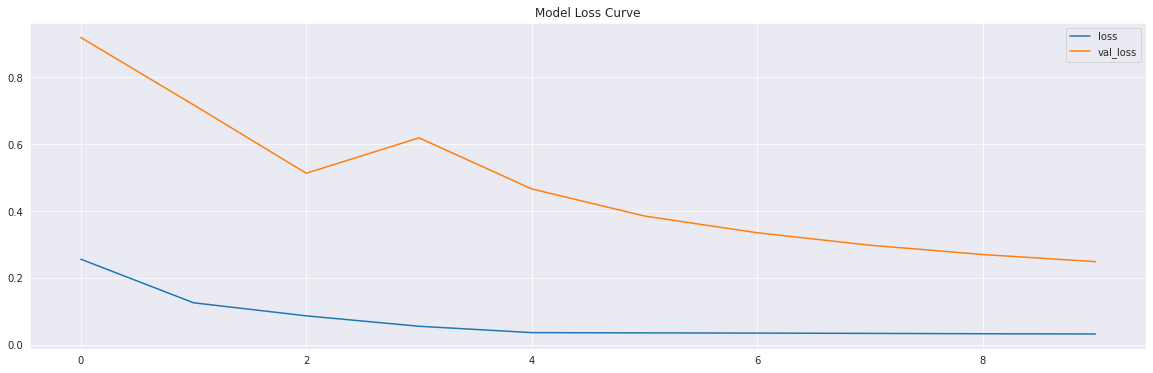

In [10]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

In [11]:
model.save('mobilenetv2.h5')

# Submission

In [12]:
submissions = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
submissions.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [13]:
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_dataframe(
    submissions,
    directory = '../input/plant-pathology-2021-fgvc8/test_images',
    x_col="image",
    y_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode=None,
    shuffle=False,
    batch_size=1
)

predictions = model.predict(test_generator,steps=len(test_generator.filenames))

Found 3 validated image filenames.


In [14]:
thresh = 0.5
for i in range(3):
    pred = ' '.join(labels.columns[1:][predictions[i] >= thresh])
    pred = 'healthy' if pred == '' else pred
    submissions.iloc[i, 1] = pred
    
submissions.to_csv('submission.csv', index=False)    